# LangGraph fundamentals

Let's start with creating an agent that analyzes a provided job description and if it fits my profile, it generated an application. We'll fake the application logic itself, and work only on the flow for now:

In [ ]:
from langchain_google_vertexai import ChatVertexAI
llm = ChatVertexAI(model="gemini-1.5-flash-002")

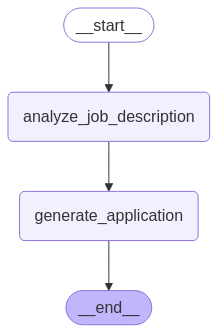

In [3]:
from typing_extensions import TypedDict

class JobApplicationState(TypedDict):
    job_description: str
    is_suitable: bool
    application: str

from langgraph.graph import StateGraph, START, END, Graph

def analyze_job_description(state):
    print("...Analyzing a provided job description ...")
    return {"is_suitable": len(state["job_description"]) > 100}

def generate_application(state):
    print("...generating application...")
    return {"application": "some_fake_application"}

builder = StateGraph(JobApplicationState)
builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)

builder.add_edge(START, "analyze_job_description")
builder.add_edge("analyze_job_description", "generate_application")
builder.add_edge("generate_application", END)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

As we can see, our graph is a *Runnable*.

In [4]:
from langchain_core.runnables import Runnable
isinstance(graph, Runnable)

True

Hence, we can run it like any *Runnable*:

In [5]:
res = graph.invoke({"job_description":"fake_jd"})
print(res)

...Analyzing a provided job description ...
...generating application...
{'job_description': 'fake_jd', 'is_suitable': False, 'application': 'some_fake_application'}


Now, let's make our logic a little bit more complex and make an edge conditional - in other words, our flow would depend on the previous outcomes (of an LLM):

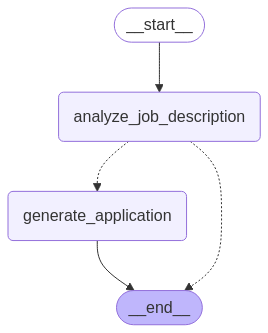

In [6]:
from typing import Literal

builder = StateGraph(JobApplicationState)
builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)

def is_suitable_condition(state: StateGraph) -> Literal["generate_application", END]:
    if state.get("is_suitable"):
        return "generate_application"
    return END

builder.add_edge(START, "analyze_job_description")
builder.add_conditional_edges("analyze_job_description", is_suitable_condition)
builder.add_edge("generate_application", END)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

Let's see how we can defined state fields that accumulate values. The first option is to use a default reducer that replaces the values in the state:

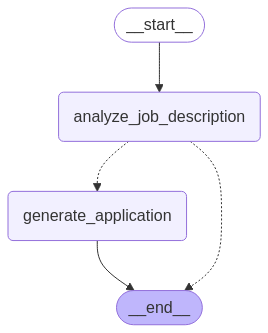

In [7]:
class JobApplicationState(TypedDict):
    job_description: str
    is_suitable: bool
    application: str
    actions: list[str]

def analyze_job_description(state):
    print("...Analyzing a provided job description ...")
    result = {
        "is_suitable": len(state["job_description"]) < 100,
        "actions": ["action1"]}
    return result

def generate_application(state):
    print("...generating application...")
    return {"application": "some_fake_application", "actions": ["action2"]}



builder = StateGraph(JobApplicationState)
builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)
builder.add_edge(START, "analyze_job_description")
builder.add_conditional_edges("analyze_job_description", is_suitable_condition)
builder.add_edge("generate_application", END)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
async for chunk in graph.astream(
    input={"job_description":"fake_jd"},
    stream_mode="values"
):
    print(chunk)
    print("\n\n")

{'job_description': 'fake_jd'}



...Analyzing a provided job description ...
{'job_description': 'fake_jd', 'is_suitable': True, 'actions': ['action1']}



...generating application...
{'job_description': 'fake_jd', 'is_suitable': True, 'application': 'some_fake_application', 'actions': ['action2']}





Option 2 - use `add` method as a reducer:

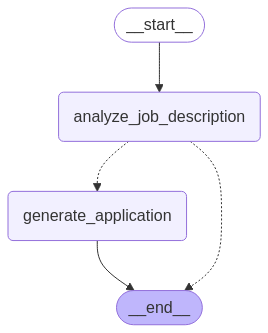

In [9]:
from typing import Annotated, Optional
from operator import add

class JobApplicationState(TypedDict):
    job_description: str
    is_suitable: bool
    application: str
    actions: Annotated[list[str], add]

def analyze_job_description(state):
    print("...Analyzing a provided job description ...")
    result = {
        "is_suitable": len(state["job_description"]) < 100,
        "actions": ["action1"]}
    return result

def generate_application(state):
    print("...generating application...")
    return {"application": "some_fake_application", "actions": ["action2"]}



builder = StateGraph(JobApplicationState)
builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)
builder.add_edge(START, "analyze_job_description")
builder.add_conditional_edges("analyze_job_description", is_suitable_condition)
builder.add_edge("generate_application", END)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
async for chunk in graph.astream(
    input={"job_description":"fake_jd"},
    stream_mode="values"
):
    print(chunk)
    print("\n\n")

{'job_description': 'fake_jd', 'actions': []}



...Analyzing a provided job description ...
{'job_description': 'fake_jd', 'is_suitable': True, 'actions': ['action1']}



...generating application...
{'job_description': 'fake_jd', 'is_suitable': True, 'application': 'some_fake_application', 'actions': ['action1', 'action2']}





And the last option is to build your own custom reducer:

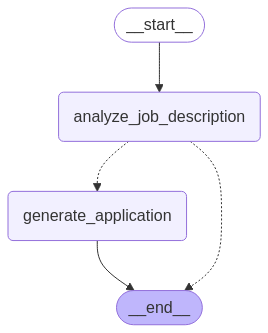

In [11]:
from typing import Annotated, Optional, Union
from operator import add

def my_reducer(left: list[str], right: Optional[Union[str, list[str]]]) -> list[str]:
  if right:
    return left + [right] if isinstance(right, str) else left + right
  return left


class JobApplicationState(TypedDict):
    job_description: str
    is_suitable: bool
    application: str
    actions: Annotated[list[str], my_reducer]

def analyze_job_description(state):
    print("...Analyzing a provided job description ...")
    result = {
        "is_suitable": len(state["job_description"]) < 100,
        "actions": "action1"}
    return result

def generate_application(state):
    print("...generating application...")
    return {"application": "some_fake_application", "actions": ["action2", "action3"]}



builder = StateGraph(JobApplicationState)
builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)
builder.add_edge(START, "analyze_job_description")
builder.add_conditional_edges("analyze_job_description", is_suitable_condition)
builder.add_edge("generate_application", END)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
async for chunk in graph.astream(
    input={"job_description":"fake_jd"},
    stream_mode="values"
):
    print(chunk)
    print("\n\n")

{'job_description': 'fake_jd', 'actions': []}



...Analyzing a provided job description ...
{'job_description': 'fake_jd', 'is_suitable': True, 'actions': ['action1']}



...generating application...
{'job_description': 'fake_jd', 'is_suitable': True, 'application': 'some_fake_application', 'actions': ['action1', 'action2', 'action3']}





How we can add configuration to our graph:

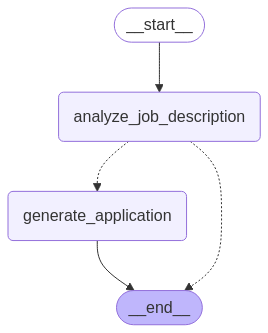

In [13]:
from langchain_core.runnables.config import RunnableConfig

def generate_application(state: JobApplicationState, config: RunnableConfig):
    model_provider = config["configurable"].get("model_provider", "Google")
    model_name = config["configurable"].get("model_name", "gemini-1.5-flash-002")
    print(f"...generating application with {model_provider} and {model_name} ...")
    return {"application": "some_fake_application", "actions": ["action2", "action3"]}



builder = StateGraph(JobApplicationState)
builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)
builder.add_edge(START, "analyze_job_description")
builder.add_conditional_edges("analyze_job_description", is_suitable_condition)
builder.add_edge("generate_application", END)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
res = graph.invoke({"job_description":"fake_jd"})
print(res)

...Analyzing a provided job description ...
...generating application with Google and gemini-1.5-flash-002 ...
{'job_description': 'fake_jd', 'is_suitable': True, 'application': 'some_fake_application', 'actions': ['action1', 'action2', 'action3']}


In [15]:
res = graph.invoke({"job_description":"fake_jd"}, config={"configurable": {"model_provider": "OpenAI", "model_name": "gpt-4o"}})
print(res)

...Analyzing a provided job description ...
...generating application with OpenAI and gpt-4o ...
{'job_description': 'fake_jd', 'is_suitable': True, 'application': 'some_fake_application', 'actions': ['action1', 'action2', 'action3']}
